# Preamble

## setup of environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/Few-Shot Project/registration-vxm/source-code

/content/gdrive/.shortcut-targets-by-id/1kJ6hvD4S-gF34kZ670rDNwU-KvWnQSXg/Few-Shot Project/registration-vxm/source-code


## pystrum

In [3]:
# !git clone https://github.com/adalca/pystrum

In [4]:
!pip install ./pystrum

Processing ./pystrum
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pystrum: filename=pystrum-0.2-py3-none-any.whl size=19534 sha256=162c7dda38af3442edf655aed74dd871cae12461bd8ad069100d49fb5656bc62
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3zfgb8d/wheels/99/09/04/4ea81ee47327b5ba906071e0eb1051e8ec16e25536660e22a0
Successfully built pystrum
  Attempting uninstall: pystrum
    Found existing installation: pystrum 0.2
    Uninstalling pystrum-0.2:
      Successfully uninstalled pystrum-0.2


## neurite

In [5]:
# !git clone https://github.com/adalca/neurite

In [6]:
!pip install ./neurite

Processing ./neurite
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for neurite: filename=neurite-0.1-py3-none-any.whl size=105915 sha256=1842a18ad0ef1194c30fafac06ec314654cdfb8544d0089c2bf2c9b516f08e53
  Stored in directory: /tmp/pip-ephem-wheel-cache-te0rr15l/wheels/ba/31/f7/f1d25b42595ca1b6eab2f256a897494e4ce015cefae23980a0
Successfully built neurite
  Attempting uninstall: neurite
    Found existing installation: neurite 0.1
    Uninstalling neurite-0.1:
      Successfully uninstalled neurite-0.1


## voxelmorph

In [7]:
# !git clone https://github.com/voxelmorph/voxelmorph

In [8]:
!pip install ./voxelmorph

Processing ./voxelmorph
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for voxelmorph: filename=voxelmorph-0.1-py3-none-any.whl size=53386 sha256=701bb20ccfd30d55b23c669b27344fa7a82c4afb83d632782a4e22c13fc01dd0
  Stored in directory: /tmp/pip-ephem-wheel-cache-u3yrjs7r/wheels/bf/cb/41/1f1122f97e110f55434ab3caa4ab750b0e3f21c8d310cb69a2
Successfully built voxelmorph
  Attempting uninstall: voxelmorph
    Found existing installation: voxelmorph 0.1
    Uninstalling voxelmorph-0.1:
      Successfully uninstalled voxelmorph-0.1


## imports

In [9]:
!pip install tqdm -q
!pip install pypng -q

In [10]:
# imports
import os, sys
import glob
from tqdm import tqdm
import time
import png
import numpy as np
import shutil
import imageio
import pickle
import random
import torch

In [11]:
# local imports
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import neurite as ne

---

# Data

In [12]:
%cd ../

/content/gdrive/.shortcut-targets-by-id/1kJ6hvD4S-gF34kZ670rDNwU-KvWnQSXg/Few-Shot Project/registration-vxm


## load & normalize

In [13]:
# load
with open('../structured-data/patients_images.pkl', 'rb') as f:
    patients = pickle.load(f)

In [14]:
# normalize data
for p_id in patients.keys():
    max_ = patients.get(p_id).max()
    patients[p_id] = patients.get(p_id).astype('float')/max_

In [15]:
# verify
for p_id in patients.keys():
    print(str(p_id) + ":", patients.get(p_id).min(), "-", patients.get(p_id).max()) 

1: 0.0 - 1.0
2: 0.0 - 1.0
3: 0.0 - 1.0
5: 0.0 - 1.0
8: 0.0 - 1.0
10: 0.0 - 1.0
13: 0.0 - 1.0
15: 0.0 - 1.0
19: 0.0 - 1.0
20: 0.0 - 1.0
21: 0.0 - 1.0
22: 0.0 - 1.0
31: 0.0 - 1.0
32: 0.0 - 1.0
33: 0.0 - 1.0
34: 0.0 - 1.0
36: 0.0 - 1.0
37: 0.0 - 1.0
38: 0.0 - 1.0
39: 0.0 - 1.0


## visualize

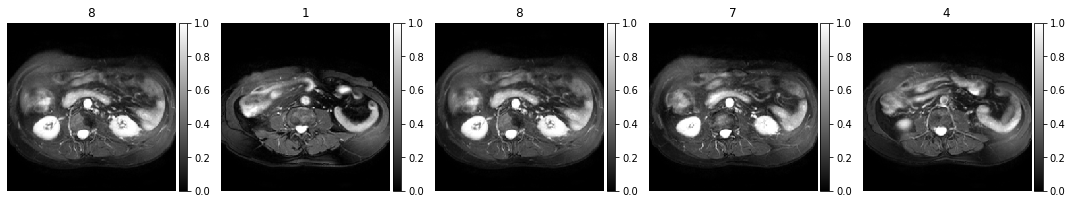

In [16]:
p_id = np.random.choice(list(patients.keys()), 1)[0]
idx = np.random.randint(0, patients.get(p_id).shape[0], size=5)

# visualize
examples = [e for e in patients.get(p_id)[idx, ...]]
ne.plot.slices(examples, cmaps=['gray'], do_colorbars=True, titles=idx, imshow_args=[{'origin':'lower'}]);

---

## data_generator

In [17]:
def data_generator(patients, bs, patient_id=None, slice_ids=[]):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """
    
    if len(slice_ids) != 0:
        bs = len(slice_ids)
    
    # extract data shape and dimension
    vol_shape = list(patients.values())[0].shape[1:] 
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([bs, *vol_shape, ndims])
    
    while True:
        if patient_id is None:
            patient_id = np.random.choice(list(patients.keys()), 1)[0]
        patient = np.array(patients.get(patient_id))

        if len(slice_ids) == 0:
            slice_ids = np.random.randint(0, patient.shape[0] - 1, size=bs)
        slice_ids = np.array(slice_ids)

        moving_images = patient[slice_ids, ..., np.newaxis]
        fixed_images = patient[slice_ids + 1, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image)
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

# Args

In [18]:
class Args():
    def __init__(self):        
        self.lr = 0.001
        self.epochs = 10
        self.batch_size = 16
        self.lam = 0.01
        self.loss = 'mse'
        self.load_model = None
        self.steps_per_epoch = 200
        self.initial_epoch = 0
        self.int_steps = 7
        self.int_downsize = 2
        self.model_dir = './trained-models/torch/1/'

In [19]:
 args = Args()

# Model

In [20]:
train_generator = data_generator(patients, bs=args.batch_size)
inshape = next(train_generator)[0][0].shape[1:-1]

In [21]:
device = 'cuda'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.backends.cudnn.deterministic = True

In [22]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

if args.load_model:
    model = vxm.networks.VxmDense.load(args.load_model, device)
else:
    model = vxm.networks.VxmDense(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
        int_steps=args.int_steps,
        int_downsize=args.int_downsize
    )

model.to(device)
_ = model.train()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [24]:
if args.loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif args.loss == 'mse':
    image_loss_func = vxm.losses.MSE().loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

losses = [image_loss_func]
weights = [1]
losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss]
weights += [args.lam]

# Train

In [25]:
os.makedirs(args.model_dir, exist_ok=True)

In [26]:
for epoch in range(args.initial_epoch, args.epochs):

    # save model checkpoint
    if epoch % 20 == 0:
        model.save(os.path.join(args.model_dir, '%04d.pt' % epoch))

    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(args.steps_per_epoch):

        step_start_time = time.time()

        # generate inputs (and true outputs) and convert them to tensors
        inputs, y_true = next(train_generator)
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in y_true]

        # run inputs through the model to produce a warped image and flow field
        y_pred = model(*inputs)

        # calculate total loss
        loss = 0
        loss_list = []
        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get compute time
        epoch_step_time.append(time.time() - step_start_time)

    # print epoch info
    epoch_info = 'Epoch %d/%d' % (epoch + 1, args.epochs)
    time_info = '%.4f sec/step' % np.mean(epoch_step_time)
    losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
    loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
    print(' - '.join((epoch_info, time_info, loss_info)), flush=True)

# final model save
model.save(os.path.join(args.model_dir, '%04d.pt' % args.epochs))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Epoch 1/10 - 0.3920 sec/step - loss: 3.0890e-03  (2.9619e-03, 1.2711e-04)
Epoch 2/10 - 0.3950 sec/step - loss: 2.0589e-03  (1.7869e-03, 2.7201e-04)
Epoch 3/10 - 0.3954 sec/step - loss: 1.7525e-03  (1.4640e-03, 2.8852e-04)
Epoch 4/10 - 0.3954 sec/step - loss: 1.6635e-03  (1.3556e-03, 3.0788e-04)
Epoch 5/10 - 0.3951 sec/step - loss: 1.6274e-03  (1.3093e-03, 3.1815e-04)
Epoch 6/10 - 0.3957 sec/step - loss: 1.6103e-03  (1.2864e-03, 3.2386e-04)
Epoch 7/10 - 0.3957 sec/step - loss: 1.5930e-03  (1.2638e-03, 3.2919e-04)
Epoch 8/10 - 0.3956 sec/step - loss: 1.5844e-03  (1.2522e-03, 3.3219e-04)
Epoch 9/10 - 0.3954 sec/step - loss: 1.5752e-03  (1.2403e-03, 3.3492e-04)
Epoch 10/10 - 0.3954 sec/step - loss: 1.5688e-03  (1.2316e-03, 3.3720e-04)


# Results

In [ ]:
def show(vxm_model, patients, patient_id=None, slice_ids=[]):
    if patient_id is None:
        patient_id = np.random.choice(list(patients.keys()), 1)[0]
    patient = np.array(patients.get(patient_id))
    if len(slice_ids) == 0:
        slice_ids = np.random.randint(0, patient.shape[0] - 1, size=1)
    for i in slice_ids:
        # get some data
        val_generator = data_generator(patients, bs=1, patient_id=patient_id, slice_ids=[i])
        val_input, _ = next(val_generator)
        val_pred = vxm_model.predict(val_input)

        # visualize
        images = [img[0, :, :, 0] for img in val_input + val_pred] 
        titles = ['moving', 'fixed', 'moved', 'flow']
        ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, imshow_args=[{'origin':'lower'}]);

model number 0  with lam =  0.01 : 


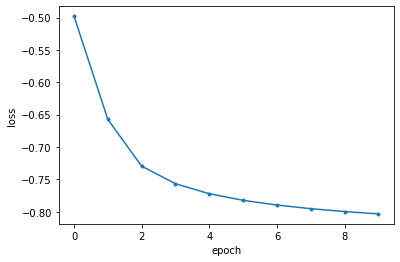

-0.8033896088600159


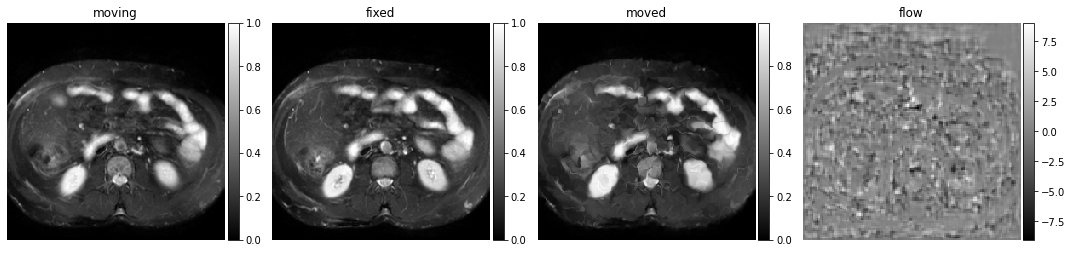

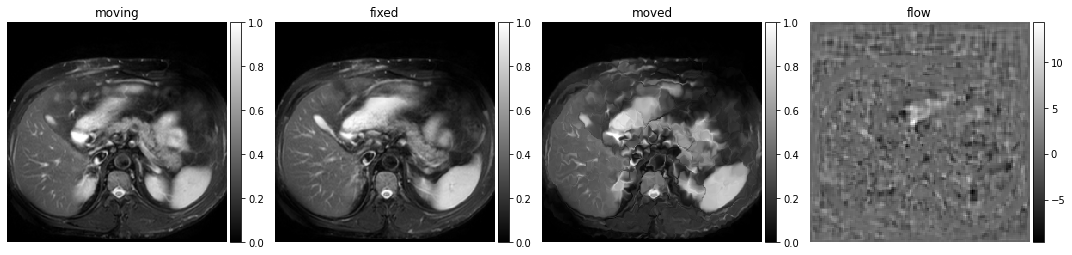

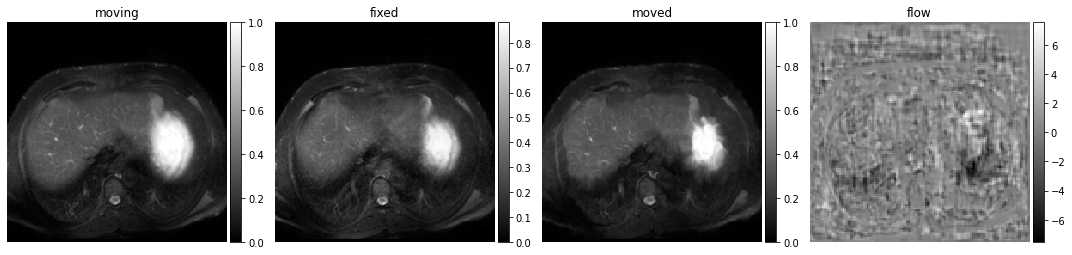

----------------------------------------------------------------------



In [ ]:
slice_ids = [5, 15, 25]
show(vxm_model, patients, slice_ids=slice_ids)
print("----------------------------------------------------------------------")